# Predicting energy production on a subset of the texas electricity grid:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook 

import os.path
import datetime as dt
import keras
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import sklearn as sk
import sklearn.preprocessing as proc
from keras.utils import plot_model
#import pydot
import tensorflow as tf
import graphviz
import random

Using TensorFlow backend.


In [2]:
# this function expands the data so the lstm is fed short time series sequences
def expand_data(xdata,timesteps):

    data_shape=(xdata.shape[0],timesteps,xdata.shape[1])   # define shape of expanded data to include repeated timesteps 
    
    x_large = np.zeros(data_shape)
    
    for i in range(timesteps,xdata.shape[0]-1):
        for j in range(0,timesteps):
            x_large[i,j,:]=xdata[i-timesteps+j,:]
            #x_large[i,j,:]=xdata[i-j,:] # reversed version

            

    return x_large


In [3]:
#This function cleans the data and creates difference column.
def clean_data_diff(df):
    #Specific data cleaning informed by visual inspection:
    df.DateTime = pd.to_datetime(df.DateTime)
    df["HB_NORTH_Difference"] = df.HB_NORTH_RealTime - df.HB_NORTH_DayAhead
    df['LZ_RAYBN_Difference'] = df.LZ_RAYBN_RealTime - df.LZ_RAYBN_DayAhead
    df.AMELIA2_8W_DayAhead[0] = df.AMELIA2_8W_DayAhead.iloc[1]
    df = df.drop(["EB1_MNSES_RealTime", "WOODROW69W_RealTime", "WOODROW69W_DayAhead", "PCP06", "PCP24"], 1)
    df.DIR = df.DIR.fillna(int(df.DIR.mode()))
    df.SPD = df.SPD.fillna(df.SPD.median())
    df.GUS = df.GUS.fillna(0)
    df.CLG = df.CLG.fillna(method="bfill")
    df.SLP = df.SLP.fillna(method="bfill")
    df.ALT = df.ALT.fillna(method="bfill")
    df.SKC = df.SKC.fillna(-5)
    df.STP = df.STP.fillna(method="bfill")
    mapping = {'CLR': 0, 'OBS': 1, 'SCT':2, 'BKN':3, 'OVC': 4}
    df = df.replace({'SKC': mapping})
    mapping = {'N':0, 'Y':1}
    df = df.replace({"DaylightSavings": mapping})
    
    #adding features
    df['year'] = df['DateTime'].apply(lambda x: x.timetuple().tm_year-2014)
    df['y_day'] = df['DateTime'].apply(lambda x: x.timetuple().tm_yday)
    df['hour'] = df['DateTime'].apply(lambda x: x.timetuple().tm_hour)
    df=df.set_index('DateTime')

    #dropping utility predictions
    df = df.drop([col for col in df.columns if "DayAhead" in col], 1)
    return df

In [4]:

#function that takes a cleaned dataframe that includes y labels and outputs scaled and normalized
#data that is in the correct format for keras LSTM. Also splits test data

def preprocess_data(data, lookback, final_test):
    x = data.drop(['HB_NORTH_RealTime','LZ_RAYBN_RealTime'], 1)
    y = data[['HB_NORTH_RealTime','LZ_RAYBN_RealTime']]
    x_scaler = proc.StandardScaler().fit(x)
    x = x_scaler.transform(x)
    y_scaler = proc.StandardScaler().fit(y)
    y = y_scaler.transform(y)    
    holder=expand_data(np.array(x),lookback) 
    #different ways to divide the data depending on whether we are tuning or testing the model:
    if final_test: 
        test_split = 24000
        x_train=holder[lookback:test_split,:,:]
        x_test=holder[test_split:(len(full_data) - 24),:,:]

        #x_train = x.iloc[:, :]
        y_train = y[(lookback + 24):(test_split + 24), :]
        #x_test = x.iloc[19000:,]
        y_test = y[(test_split + 24):,:]
    else:
        test_split = 19000
        x_train=holder[lookback:test_split,:,:]
        x_test=holder[test_split:24000,:,:]

        #x_train = x.iloc[:, :]
        y_train = y[(lookback + 24):(test_split + 24), :]
        #x_test = x.iloc[19000:,]
        y_test = y[(test_split + 24):(24000 + 24),]
   
    return (x_train,y_train,x_test,y_test, y_scaler)

# Loading and cleaning data:

In [5]:
np.random.seed(9779)
data=pd.read_csv('cleaned_data/all_the_data.csv', index_col=0)  # reads merged 

#saving utility predictions for comparison later
hb_da = data[['HB_NORTH_DayAhead','LZ_RAYBN_DayAhead']]
time = pd.to_datetime(data.DateTime)
full_data=clean_data_diff(data)
full_data = full_data.drop(['HB_NORTH_Difference', 'LZ_RAYBN_Difference'], 1)



/home/nic/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Reshaping data so it is compatible with keras

In [6]:
np.random.seed(9779)

scale=1

# reshape data
timesteps=1;    #leave this as 1 for now
lookback=6  #the number of hours in the past that the lstm looks at

time=full_data.index #create an index for time that we can use to plot things

x_train, y_train, x_test, y_test, y_scaler = preprocess_data(full_data, lookback, False)
test_split = 19000


# Keras Neural Network Design, Training, and Prediction

In [7]:
def build_lstm(x_train, y_train, losss):
    np.random.seed(9779)

    # design network
    input_shape=(x_train.shape[1], x_train.shape[2])

    model = Sequential()

    #network layers:

    model.add(LSTM(64,return_sequences=True,input_shape=input_shape,activation='tanh'))
    model.add(LSTM(64, return_sequences=True, activation='tanh'))
    model.add(LSTM(64, return_sequences=False, activation='tanh'))

    model.add(Dense(16, activation='tanh'))
    model.add(Dense(2))

    #network compiling:

    model.compile(loss=losss, optimizer='adam')
    #logcosh is the next best performing loss, and mean_squared_error does a better job of modeling outliers.

    #fit network
    history = model.fit(x_train, 
                        y_train,#[0::timesteps], 
                        epochs=50, 
                        batch_size=1000, 
                        validation_split=0.1,
                        verbose=0, 
                        shuffle=False)
    return model
model = build_lstm(x_train, y_train, "mean_absolute_error")

# predict and plot data

<IPython.core.display.Javascript object>


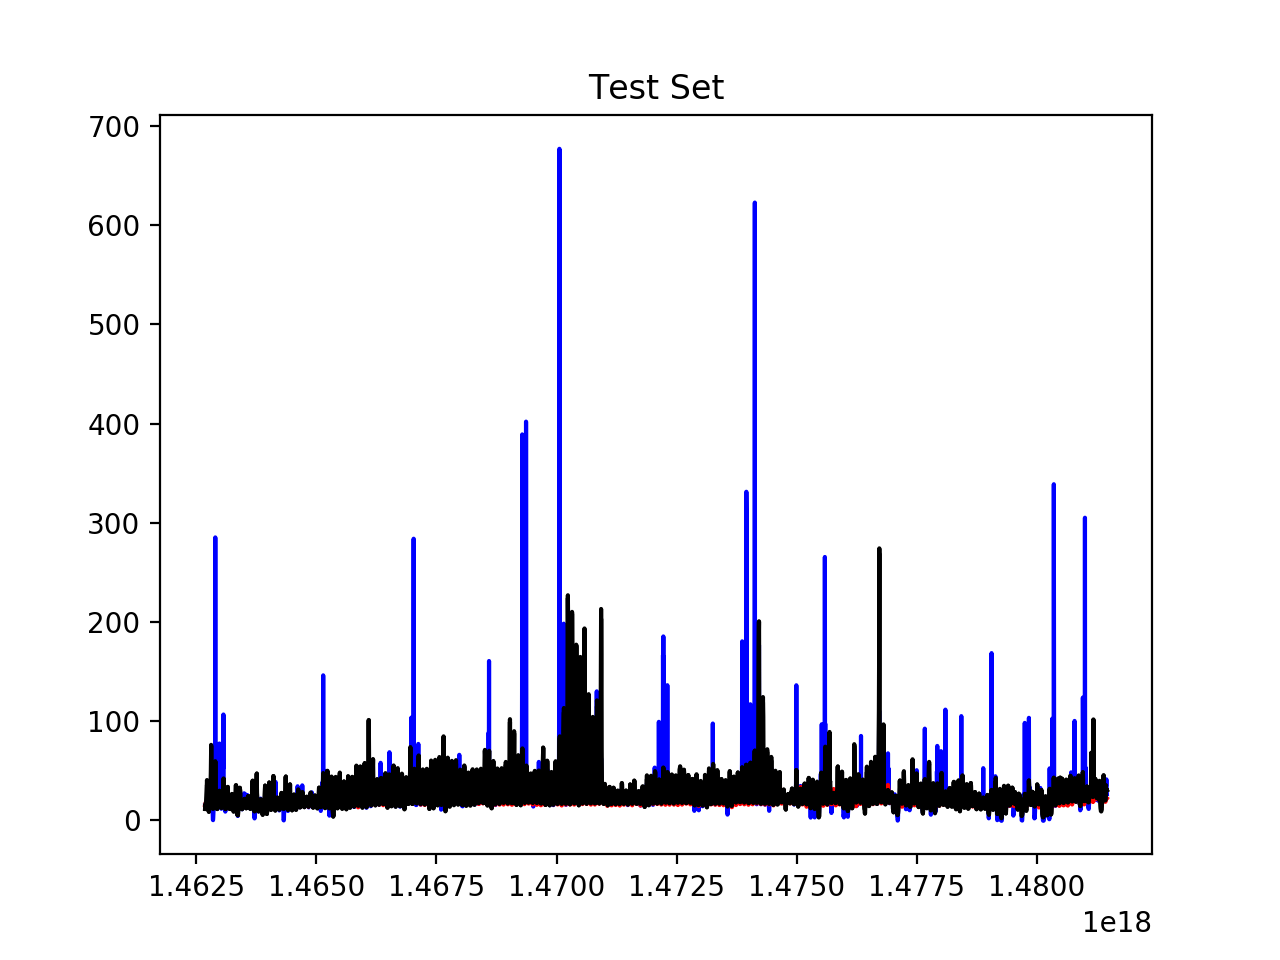

In [8]:
np.random.seed(9779)

y_training_set_predictions=model.predict(x_train,batch_size=x_train.shape[0]) 
y_test_set_predictions=model.predict(x_test,batch_size=x_test.shape[0]) 

plt.figure()

plt.plot(time[test_split:24000],
         y_scaler.inverse_transform(y_test*scale)[:,0], color = "blue")
plt.plot(time[test_split:24000],
         y_scaler.inverse_transform(y_test_set_predictions*scale)[:,0], color = "red")
plt.plot(time[test_split:24000],
         hb_da.as_matrix()[test_split+24:24000+24], color = "black")

plt.title("Test Set")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


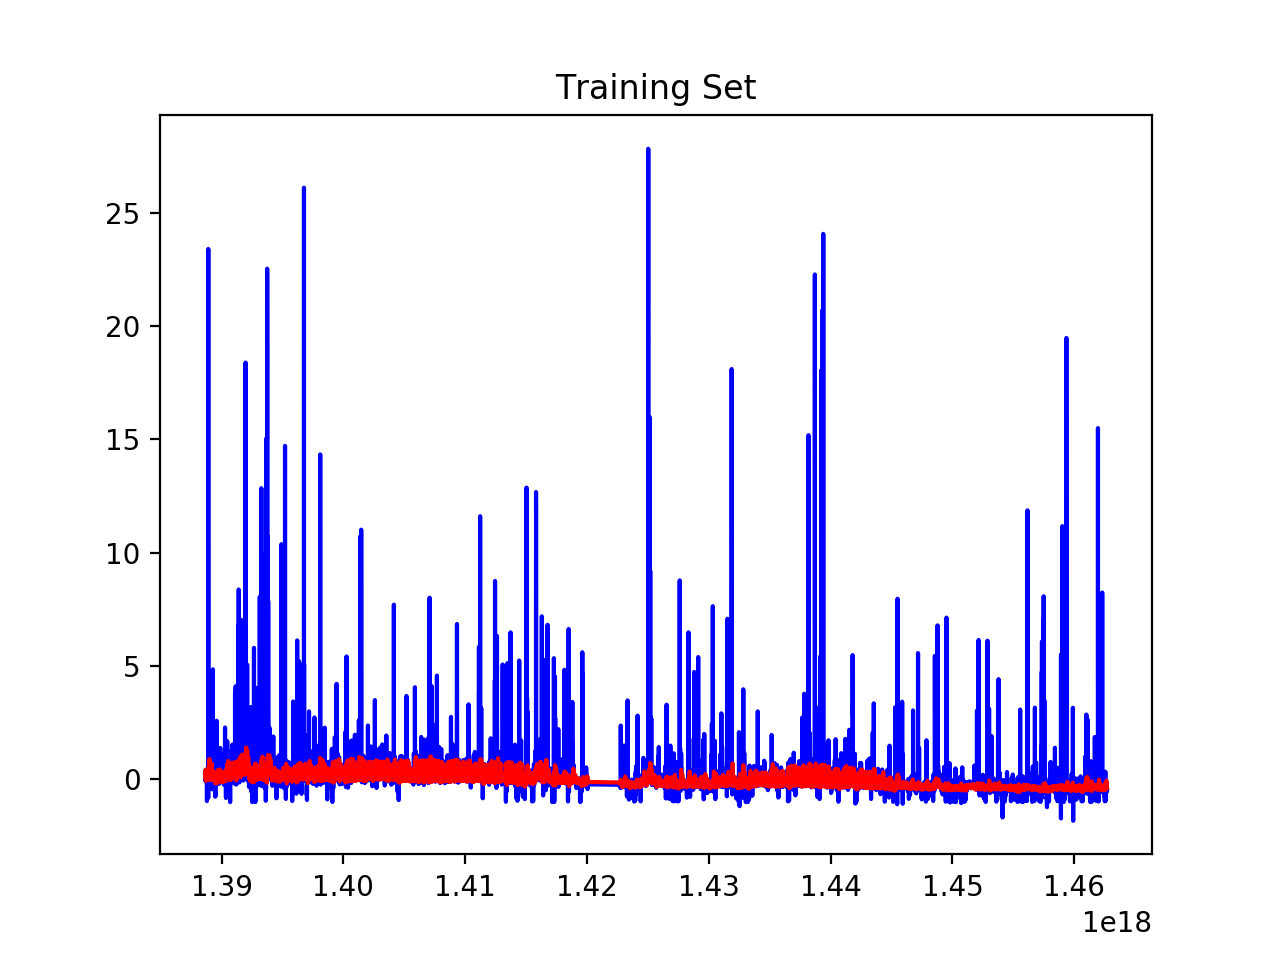

Text(0.5,1,'Training Set')

In [9]:

plt.figure()
plt.plot(time[lookback:test_split],
         y_train[:,0],
        color = "blue")
plt.plot(time[lookback:test_split],
         y_training_set_predictions[:,0],
         color = "red"
        )
plt.title("Training Set")

<IPython.core.display.Javascript object>


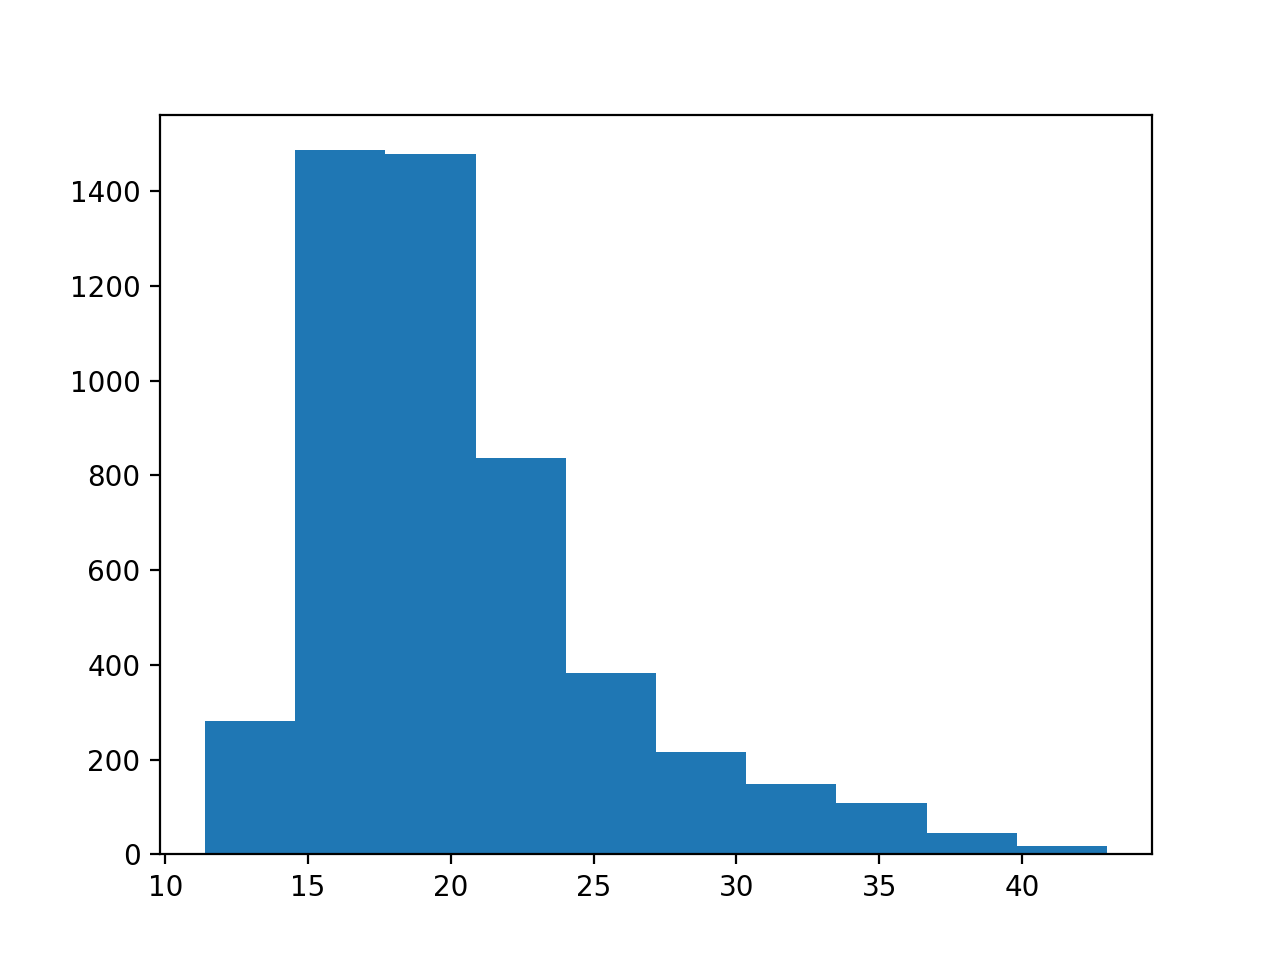

In [10]:
plt.figure()
plt.hist(y_scaler.inverse_transform(y_test_set_predictions*scale)[:,0])
plt.legend()
plt.show()


# Numerical accuracy of LSTM on the tuning set:

In [11]:
avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions*scale) - y_scaler.inverse_transform(y_test*scale)))/len(y_test_set_predictions)
avg_err_utility = sum(np.absolute(hb_da.as_matrix()[test_split+24:24000+24] - y_scaler.inverse_transform(y_test*scale)))/len(hb_da.as_matrix()[test_split+24:24000+24])
print("Tuning set results:")
print("average error of the model on the tuning set: ", avg_err_model)
print("average error of utility predictions: ", avg_err_utility)
print("average performance of our model over the utility predictions on tuning set:", sum(avg_err_utility - avg_err_model)/2)
both = (y_scaler.inverse_transform(y_test_set_predictions*scale) + hb_da.as_matrix()[test_split+24:24000+24])/2
avg_both = sum(np.absolute((both - y_scaler.inverse_transform(y_test*scale))))/len(y_test_set_predictions)
print("average error of ensemble: ", avg_both)

print("average performance of our ensemble over the utility predictions on tuning set:", sum(avg_err_utility - avg_both)/2)
print("possible total savings of: $", 24*365*1300*sum(avg_err_utility - avg_both)/2)

Tuning set results:
average error of the model on the tuning set:  [ 5.12518942  5.38081396]
average error of utility predictions:  [ 6.149796    6.33127225]
average performance of our model over the utility predictions on tuning set: 0.987532433868
average error of ensemble:  [ 4.87427763  5.05607577]
average performance of our ensemble over the utility predictions on tuning set: 1.27535742686
possible total savings of: $ 14523770.3771


In [12]:
avg_diff_of_avg = []
diff_of_std = []
losses = ['mean_squared_error', 
          'mean_absolute_error', 
          'mean_absolute_percentage_error', 
          'mean_squared_logarithmic_error', 
          'squared_hinge', 
          'hinge',
          'categorical_hinge',
          'logcosh',
          'categorical_crossentropy',
          'kullback_leibler_divergence',
          'poisson',
          'cosine_proximity']

for i in losses:
    print("validating on ", i)
    model = build_lstm(x_train, y_train, i)
    
    y_training_set_predictions=model.predict(x_train,batch_size=x_train.shape[0]) 
    y_test_set_predictions=model.predict(x_test,batch_size=x_test.shape[0]) 
    avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions*scale) - y_scaler.inverse_transform(y_test*scale)))/len(y_test_set_predictions)
    avg_err_utility = sum(np.absolute(hb_da.as_matrix()[test_split+24:24000+24] - y_scaler.inverse_transform(y_test*scale)))/len(hb_da.as_matrix()[test_split+24:24000+24])
    avg_diff_of_avg.append(sum(avg_err_model - avg_err_utility)/2)
    
    std_model = np.sqrt(sum((y_scaler.inverse_transform(y_test_set_predictions*scale) - y_scaler.inverse_transform(y_test*scale))**2)/len(y_test_set_predictions))
    std_utility = np.sqrt(sum((hb_da.as_matrix()[test_split+24:24000+24] - y_scaler.inverse_transform(y_test*scale))**2)/len(hb_da.as_matrix()[test_split+24:24000+24]))
    diff_of_std.append(sum(std_model - std_utility)/2)
    

validating on  mean_squared_error
validating on  mean_absolute_error
validating on  mean_absolute_percentage_error
validating on  mean_squared_logarithmic_error
validating on  squared_hinge
validating on  hinge
validating on  categorical_hinge
validating on  logcosh
validating on  categorical_crossentropy
validating on  kullback_leibler_divergence
validating on  poisson
validating on  cosine_proximity


In [13]:
losses_score = pd.DataFrame([losses, avg_diff_of_avg, diff_of_std]).T
losses_score.columns = ["Loss", "model_minus_utility_avg", "model_minus_utility_std"]
#losses_score.to_csv("tables/losses_score.csv")

In [14]:
losses_score

,Loss,model_minus_utility_avg,model_minus_utility_std
0,mean_squared_error,0.643266,1.03679
1,mean_absolute_error,-0.793489,0.269912
2,mean_absolute_percentage_error,0.180573,0.766958
3,mean_squared_logarithmic_error,1.22321,0.108807
4,squared_hinge,73.4841,65.5343
5,hinge,135.141,123.325
6,categorical_hinge,13.0229,8.25246
7,logcosh,-0.280194,0.0576001
8,categorical_crossentropy,29.4503,21.4937
9,kullback_leibler_divergence,26.5689,17.6424


# Final Prediction on Test Set:

In [15]:
x_train_final, y_train_final, x_test_final, y_test_final, y_scaler = preprocess_data(full_data, lookback, True)

model = build_lstm(x_train, y_train, "mean_absolute_error")
y_training_set_predictions_final = model.predict(x_train_final,batch_size=x_train_final.shape[0]) 
y_test_set_predictions_final = model.predict(x_test_final,batch_size=x_test_final.shape[0]) 

<IPython.core.display.Javascript object>


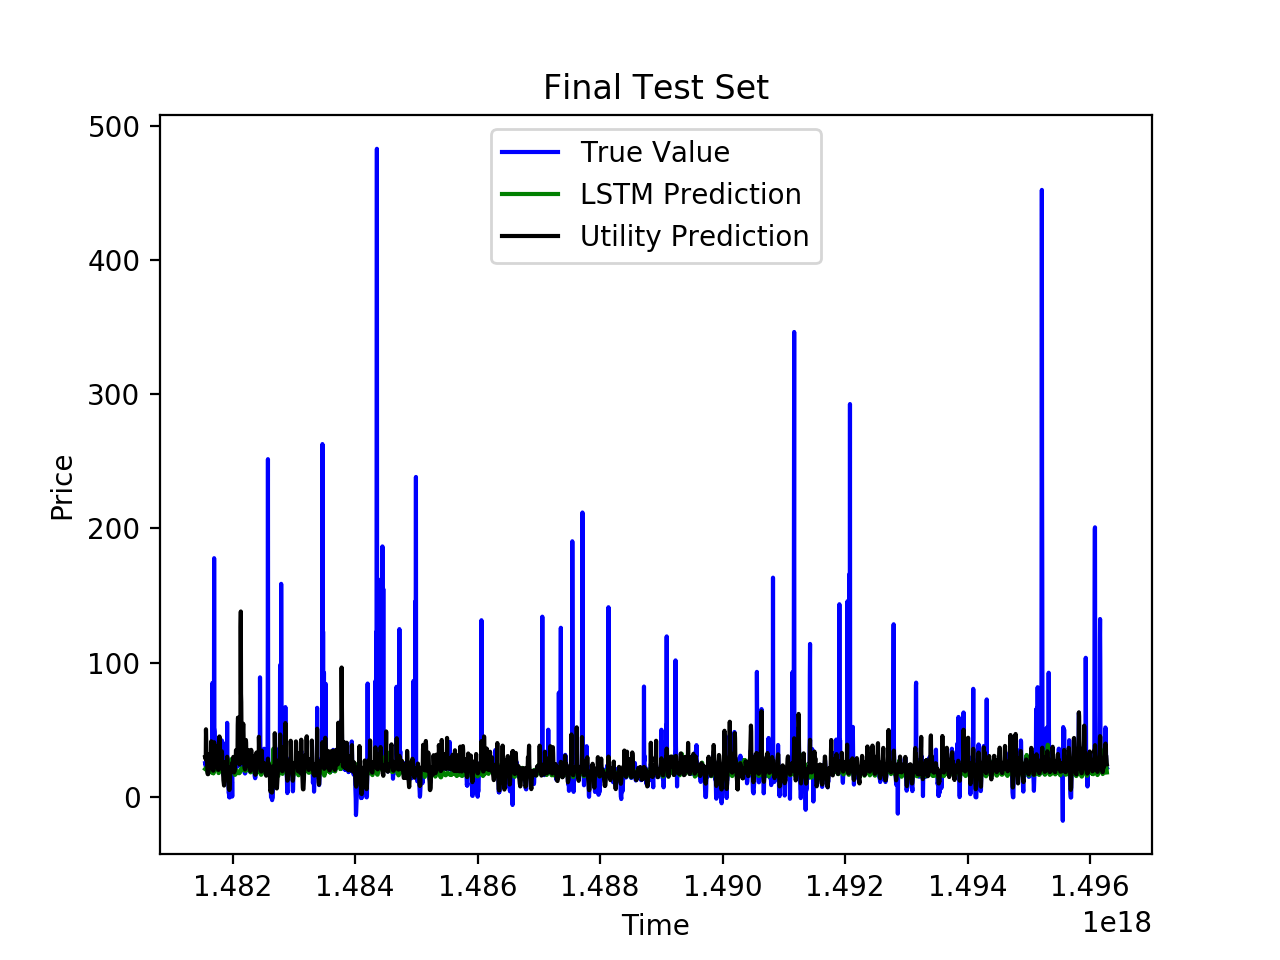

In [16]:

plt.figure()

plt.plot(time[24000 +24:],
         y_scaler.inverse_transform(y_test_final*scale)[:,0], color = "blue", label = "True Value")
plt.plot(time[24000+24:],
         y_scaler.inverse_transform(y_test_set_predictions_final*scale)[:,0], color = "green", label = "LSTM Prediction")
plt.plot(time[24000 + 24:],
         hb_da.as_matrix()[24000+24:][:,0], color = "black", label = "Utility Prediction")#,
         #color=("blue", "red", "black")
#        )

plt.title("Final Test Set")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Price")
plt.savefig("fig/macro_test_performance.png")
plt.show()

In [17]:
avg_err_model = sum(np.absolute(y_scaler.inverse_transform(y_test_set_predictions_final*scale) - y_scaler.inverse_transform(y_test_final*scale)))/len(y_test_set_predictions)
avg_err_utility = sum(np.absolute(hb_da.as_matrix()[24000+24:] - y_scaler.inverse_transform(y_test_final*scale)))/len(hb_da.as_matrix()[24000+24:])

print("average error of the model: ", avg_err_model)
print("average error of utility predictions: ", avg_err_utility)
print("average performance of our model over the utility predictions:", sum(avg_err_utility - avg_err_model)/2)
both = (y_scaler.inverse_transform(y_test_set_predictions_final*scale) + hb_da.as_matrix()[24000+24:])/2
avg_both = sum(np.absolute((both - y_scaler.inverse_transform(y_test_final*scale))))/len(y_test_set_predictions_final)
print("average error of ensemble: ", avg_both)

print("average performance of our ensemble over the utility predictions:", sum(avg_err_utility - avg_both)/2)
print("possible total savings of ensemble: $", 24*365*1300*sum(avg_err_utility - avg_both)/2)

print("possible total savings of our model alone: $", 24*365*1300*sum(avg_err_utility - avg_err_model)/2)

average error of the model:  [ 5.32285718  5.60602697]
average error of utility predictions:  [ 6.23151544  6.41564638]
average performance of our model over the utility predictions: 0.859138831074
average error of ensemble:  [ 5.68067055  5.82286798]
average performance of our ensemble over the utility predictions: 0.571811641822
possible total savings of ensemble: $ 6511790.97706
possible total savings of our model alone: $ 9783873.00827


# Visualizing errors and brainstorming solutions

In [18]:
node_hbn = np.asarray([y_scaler.inverse_transform(y_test_final*scale)[:, 0], y_scaler.inverse_transform(y_test_set_predictions_final*scale)[:, 0], hb_da.as_matrix()[24000+24:][:,0]]).T

node_hbn = pd.DataFrame(node_hbn)
node_hbn.columns = ["RT", "Model", "Utility"]
node_hbn = node_hbn.sort_values("RT")


<IPython.core.display.Javascript object>


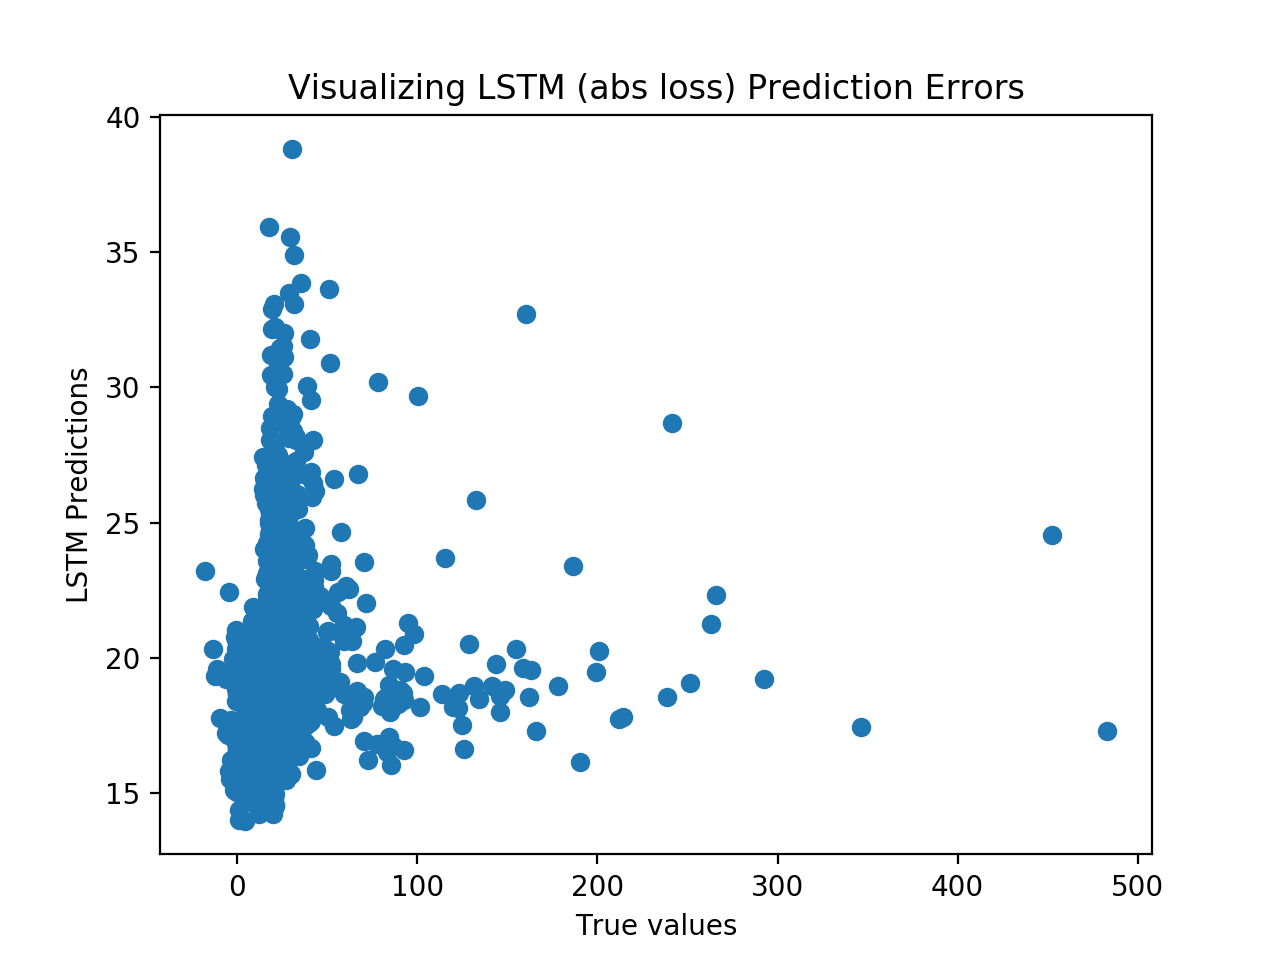

In [19]:
plt.figure()
plt.scatter(node_hbn.RT, node_hbn.Model)
plt.title("Visualizing LSTM (abs loss) Prediction Errors")
plt.xlabel("True values")
plt.ylabel("LSTM Predictions")
plt.savefig("fig/LSTM_Errors.png")
plt.show()

<IPython.core.display.Javascript object>


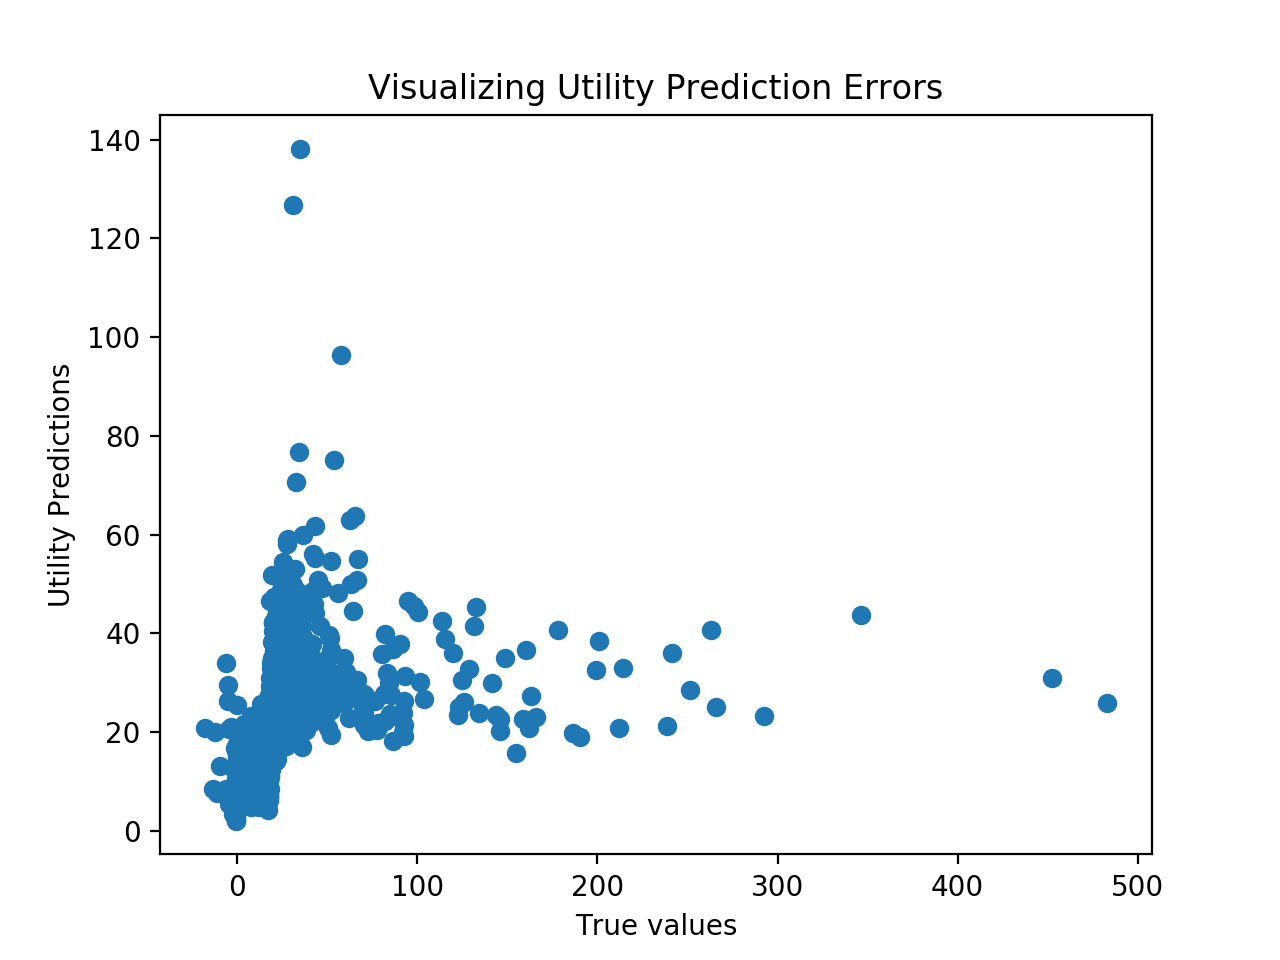

In [20]:
plt.figure()
plt.scatter(node_hbn.RT, node_hbn.Utility)
plt.title("Visualizing Utility Prediction Errors")
plt.xlabel("True values")
plt.ylabel("Utility Predictions")
plt.savefig("fig/Utility_Errors.png")
plt.show()